# Lab1 Intro
In the retail industry, understanding the Voice of the Customer (VOC) is crucial for gaining insights into customer preferences and pain points. By analyzing and categorizing customer feedback, retailers can improve their products, services, and overall customer experience.

This hands-on workshop guides participants through the process of classifying Voice of Customer (VOC) data using Amazon Titan on Amazon Bedrock.
You will be provided with sample data and will be tasked with classifying customer feedback into categories and generating a summary analysis report.

- First, you will learn how to use Prompt Engineering to classify customer feedback.
- Then, you will explore the concept of embedding techniques and use them to classify customer feedback by semantic comparison.
- After that, you will be provided with additional example data. You will explore the concept of retrieval augmented generation (RAG) and use it to enhance the classification process by dynamically retrieving relevant few-shot examples.
- At the end of the workshop, you will be able to generate a comprehensive analysis report that provides insights into the VOC data and helps retailers improve their products and services.

### A task of developing a VoC Classifier has been assigned to you:
You will be provided with a sample dataset in "data/comments.csv", each record represents a customer comment and its corresponding groundtruth category. You need to write prompt to perform the classification task using the Amazon Titan Model, and then compare the prediction result with the groundtruth and calculate the accuracy.

### Your objectives are:

- Classify each customer feedback comment into 35+ categories
- Provide the reasoning behind each classification
- Summarize each customer comment in a brief description



## 1. Install dependencies

In [29]:
!pip install -q langchain==0.2.16 langchain_aws==0.1.17 pandas==2.2.2 openpyxl==3.1.5 termcolor==2.4.0

## 2. Initialize Bedrock model using LangChain
- First let's see what 'Titan' language models we have in Bedrock

In [20]:
import boto3
import json
import copy
import pandas as pd
from termcolor import colored
# create clients of bedrock
bedrock = boto3.client(service_name='bedrock')
bedrock_runtime = boto3.client(service_name='bedrock-runtime') 
pd.set_option('display.max_rows', None)
results = []

available_models = bedrock.list_foundation_models()
for model in available_models['modelSummaries']:
    if 'Titan' in model['modelName'] and 'TEXT' in model['outputModalities']: # Only select models containing 'Titan' 
        results.append({
            'Model Name': model['modelName'],
            'Model ID': model['modelId'],  # Add Model ID column
            'Provider': model['providerName'],
            'Input Modalities': ', '.join(model['inputModalities']),
            'Output Modalities': ', '.join(model['outputModalities']),
            'Streaming': model.get('responseStreamingSupported', 'N/A'),
            'Status': model['modelLifecycle']['status']
        })

df = pd.DataFrame(results)
display(df)

pd.reset_option('display.max_rows')

,Model Name,Model ID,Provider,Input Modalities,Output Modalities,Streaming,Status
0,Titan Text Large,amazon.titan-tg1-large,Amazon,TEXT,TEXT,True,ACTIVE
1,Titan Text G1 - Premier,amazon.titan-text-premier-v1:0,Amazon,TEXT,TEXT,True,ACTIVE
2,Titan Text G1 - Lite,amazon.titan-text-lite-v1:0:4k,Amazon,TEXT,TEXT,True,ACTIVE
3,Titan Text G1 - Lite,amazon.titan-text-lite-v1,Amazon,TEXT,TEXT,True,ACTIVE
4,Titan Text G1 - Express,amazon.titan-text-express-v1:0:8k,Amazon,TEXT,TEXT,True,ACTIVE
5,Titan Text G1 - Express,amazon.titan-text-express-v1,Amazon,TEXT,TEXT,True,ACTIVE


- We use [Langchain](https://www.langchain.com/) SDK to build the application
- Initialize a ChatBedrock object with Amzon Titan Text model, the model id is "amazon.titan-text-premier-v1:0"

In [21]:
from langchain_aws import ChatBedrock
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_core.output_parsers import StrOutputParser,XMLOutputParser
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder,HumanMessagePromptTemplate

model_id = "amazon.titan-text-premier-v1:0" 
llm = ChatBedrock( model_id=model_id,
                  streaming=False,
                # callbacks=[StreamingStdOutCallbackHandler()],
                model_kwargs=dict(temperature=0.0,maxTokenCount=3072)
                 )

- test run

In [22]:
messages = [
    (
        "system",
        "You are a helpful assistant that translates English to French. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]
llm.invoke(messages)

AIMessage(content='Je suis amoureux de la programmation.', additional_kwargs={'usage': {'prompt_tokens': 23, 'completion_tokens': 12, 'total_tokens': 35}, 'stop_reason': None, 'model_id': 'amazon.titan-text-premier-v1:0'}, response_metadata={'usage': {'prompt_tokens': 23, 'completion_tokens': 12, 'total_tokens': 35}, 'stop_reason': None, 'model_id': 'amazon.titan-text-premier-v1:0'}, id='run-00b266c6-6b9f-4c2a-b2c4-e5cf7ee3022e-0', usage_metadata={'input_tokens': 23, 'output_tokens': 12, 'total_tokens': 35})

## 3. Preparing the Dataset to be classified. 
- The data (Voice of Customers) is subject to experiment usage only

### Load the customer review data

- Load the examples data to classify

In [23]:
comments_filepath = "data/comments_9.csv"
comments = pd.read_csv(comments_filepath)
display(comments)

,comment,groundtruth
0,"After switching to a new operating system, my ...",Charging failure
1,"After 10 months, my phone's battery health has...",Abnormal battery health
2,"Yesterday, the battery health was still 94%. B...",Abnormal battery health
3,The camera quality of my smartphone has been q...,Camera color deviation
4,"The update speed of this phone is really slow,...",Update delay
...,...,...
195,My phone's been acting up for a while now. The...,Unresponsive screen
196,"After the recent software update, my device ha...","Automatic restart, shutdown"
197,Every major software update seems to cause iss...,SIM card not detected
198,"My phone has been getting slower and slower, a...",High storage usage


- List categories values

In [24]:
category_definition = "data/categories.csv"
categories = pd.read_csv(category_definition)
display(categories['mappings'].values)

array(['Camera lens glare', 'CarPlay connection failure', 'Update delay',
       'Camera dust and dirt', 'Automatic restart, shutdown',
       'High storage usage', 'Poor manufacturing quality',
       'Frame rate drop', 'Camera black screen', 'App crashes',
       'Third-party charger, data cable incompatibility',
       'Screen flickering', 'User interface errors',
       'Abnormal battery health', 'Weak signal', 'Unresponsive screen',
       'Data loss after update', 'Screen color deviation',
       'Widget display failure', 'SIM card not detected', 'Overheating',
       'Charging failure', 'Easily retains fingerprints',
       'Activation failure', 'Face ID malfunction', 'Fast battery drain',
       'Update failure', 'Wi-Fi connection failure', 'Slow update',
       'Third-party app incompatibility', 'Camera color deviation',
       'Slow or failed data migration', 'Others', 'Lag and stuttering',
       'Device freezing'], dtype=object)

## 4. Define system prompt and user prompt template

In [25]:
system = """You are a professional  customer feedback analyst. Your daily task is to categorize user feedback.
You will be given an input in the form of a JSON array. Each object in the array contains a comment ID and a 'c' field representing the user's comment content.
Your role is to analyze these comments and categorize them appropriately.
Please note:
1. Only output valid XML format data.
2. Do not include any explanations or additional text outside the XML structure.
3. Ensure your categorization is accurate and consistent.
4. If you encounter any ambiguous cases, use your best judgment based on the context provided.
5. Maintain a professional and neutral tone in your categorizations.
"""

user = """
Please categorize user comments according to the following category tags library:
<categories>
{tags}
</categories>

Please follow these instructions for categorization:
<instruction>
1. Categorize each comment using the tags above. If no tags apply, output "Others".
2. Summarize the comment content in no more than 50 words. Replace any double quotation marks with single quotation marks.
</instruction>

Below are the customer comments records to be categorized. The input is an array, where each element has an 'id' field representing the complaint ID and a 'c' field summarizing the complaint content.
<comments>
{input}
</comments>

For each record, summarize the comment, categorize according to the category explainations, and return the  ID, summary , reasons for tag matches, and category.

Output format example:
<output>
  <item>
    <id>xxx</id>
    <summary>xxx</summary>
    <reason>xxx</reason>
    <category>xxx</category>
  </item>
</output>

Skip the preamble and output only valid XML format data. Remember:
- Avoid double quotation marks within quotation marks. Use single quotation marks instead.
- Replace any double quotation marks in the content with single quotation marks.
"""

## 5. Define Langchain

- Create a langchain chat template

In [26]:
prompt = ChatPromptTemplate([
    ('system',system),
    ('user',user),
    ],
    partial_variables={'tags':categories['mappings'].values}
)
chain = prompt | llm | XMLOutputParser()

- convert the comments to data array

In [27]:
sample_data = [str({"id":'s_'+str(i),"comment":x[0]}) for i,x in enumerate(comments.values)]
print("\n".join(sample_data[:3]))

{'id': 's_0', 'comment': "After switching to a new operating system, my phone is no longer able to charge. I've tried updating to the latest version, but it still won't charge. The issue seems to be getting worse. #tech"}
{'id': 's_1', 'comment': "After 10 months, my phone's battery health has dropped to 95%. The system is quite smooth, but the battery life is just okay. The messaging app does seem a bit more responsive now, which is a small improvement. [Sad emoji]"}
{'id': 's_2', 'comment': "Yesterday, the battery health was still 94%. But when I woke up today, it had dropped to 93% [shocked emoji][shocked emoji][shocked emoji] \nHow can I save my battery? I still have about a month and a half left on the warranty, but it's unlikely it will reach 80% [crying laughing emoji]\nAnd it seems like getting it repaired at the service center would require me to wipe all the data on my phone. That's such a hassle..."}


### Option 1. iterate comment one by one to get the categorization

In [10]:
import math,json
resps = []
for i in range(len(sample_data)):
    data = sample_data[i]
    print(colored(f"*****[{i}]*****input:\n{data}","blue"))
    resp = chain.invoke(data)
    print(colored(f"****response*****\n{resp}","green"))
    # resps += json.loads(resp)
    for item in resp['output']:
        row={}
        for it in item['item']:
            row[list(it.keys())[0]]=list(it.values())[0]
        resps.append(row)

*****[0]*****input:
{'id': 's_0', 'comment': "After switching to a new operating system, my phone is no longer able to charge. I've tried updating to the latest version, but it still won't charge. The issue seems to be getting worse. #tech"}
****response*****
{'output': [{'item': [{'id': 's_0'}, {'summary': "'After switching to a new operating system, my phone is no longer able to charge. I've tried updating to the latest version, but it still won't charge. The issue seems to be getting worse. #tech'"}, {'reason': 'The user is experiencing charging failure after updating the operating system.'}, {'category': 'Charging failure'}]}]}
*****[1]*****input:
{'id': 's_1', 'comment': "After 10 months, my phone's battery health has dropped to 95%. The system is quite smooth, but the battery life is just okay. The messaging app does seem a bit more responsive now, which is a small improvement. [Sad emoji]"}
****response*****
{'output': [{'item': [{'id': 's_1'}, {'summary': "The phone's battery h

### Option 2. This option will run in batches (20 records per batch)
- You can uncomment the following code to try differently

In [28]:
choose = input("Are you confirm to run option 2? Y/N")

if choose in ['Y','y']:
    import math,json
    batch_size = 20
    batch = math.ceil(comments.shape[0]/batch_size)
    i = 0
    resps = []
    for i in range(batch):
        print(colored(f"****[{i}]*****\n","blue"))
        data = sample_data[i*batch_size:(i+1)*batch_size]
        resp = chain.invoke(data)
        print(colored(f"****response*****\n{resp}","green"))
        for item in resp['output']:
            row={}
            for it in item['item']:
                row[list(it.keys())[0]]=list(it.values())[0]
            resps.append(row)

Are you confirm to run option 2? Y/N y


****[0]*****

****response*****
{'output': [{'item': [{'id': 's_0'}, {'summary': 'The phone is unable to charge after switching to a new operating system.'}, {'reason': 'The user is experiencing charging failure after updating the operating system.'}, {'category': 'Charging failure'}]}, {'item': [{'id': 's_1'}, {'summary': "The phone's battery health has dropped to 95% after 10 months."}, {'reason': 'The user is experiencing abnormal battery health.'}, {'category': 'Abnormal battery health'}]}, {'item': [{'id': 's_2'}, {'summary': 'The battery health dropped from 94% to 93% overnight.'}, {'reason': 'The user is experiencing abnormal battery health.'}, {'category': 'Abnormal battery health'}]}, {'item': [{'id': 's_3'}, {'summary': 'The camera quality is disappointing, with color deviation and distortion.'}, {'reason': 'The user is experiencing camera color deviation and distortion.'}, {'category': 'Camera color deviation'}]}, {'item': [{'id': 's_4'}, {'summary': 'The update speed is slo

ValueError: Error raised by bedrock service: Read timeout on endpoint URL: "https://bedrock-runtime.us-east-1.amazonaws.com/model/amazon.titan-text-premier-v1%3A0/invoke"

- covert the data array to pandas dataframe

In [30]:
prediction_df = pd.DataFrame(resps).rename(columns={"category":"predict_label"}).drop_duplicates(['id']).reset_index(drop='index')
# convert the label value to lowercase
prediction_df['predict_label'] = prediction_df['predict_label'].apply(lambda x: x.strip().lower().replace("'",""))
prediction_df

,id,summary,reason,predict_label
0,s_0,The phone is unable to charge after switching ...,The user is experiencing charging failure afte...,charging failure
1,s_1,The phone's battery health has dropped to 95% ...,The user is experiencing abnormal battery health.,abnormal battery health
2,s_2,The battery health dropped from 94% to 93% ove...,The user is experiencing abnormal battery health.,abnormal battery health
3,s_3,"The camera quality is disappointing, with colo...",The user is experiencing camera color deviatio...,camera color deviation
4,s_4,"The update speed is slow, and the phone is alw...",The user is experiencing slow update.,slow update
...,...,...,...,...
175,s_175,The signal is weak after the latest update.,The user describes the signal being weak after...,weak signal
176,s_176,The phone fails to connect to the in-car system.,The user describes the phone failing to connec...,carplay connection failure
177,s_177,The operating system update causes issues with...,The user describes issues with the messaging a...,update failure
178,s_178,The phone is uncomfortable to use due to slow ...,The user describes the phone being uncomfortab...,unresponsive screen


### Merge the prediction result to the groundtruth and Calculate the accuracy

- copy comments to ground_truth dataframe

In [36]:
ground_truth = comments.copy()
# convert the label value to lowercase
ground_truth['groundtruth'] = ground_truth['groundtruth'].apply(lambda x: x.strip().lower())
ground_truth

,comment,groundtruth
0,"After switching to a new operating system, my ...",charging failure
1,"After 10 months, my phone's battery health has...",abnormal battery health
2,"Yesterday, the battery health was still 94%. B...",abnormal battery health
3,The camera quality of my smartphone has been q...,camera color deviation
4,"The update speed of this phone is really slow,...",update delay
...,...,...
195,My phone's been acting up for a while now. The...,unresponsive screen
196,"After the recent software update, my device ha...","automatic restart, shutdown"
197,Every major software update seems to cause iss...,sim card not detected
198,"My phone has been getting slower and slower, a...",high storage usage


- merge the date prediction to the groudtruth data

In [37]:
# merge_df=pd.merge(ground_truth,prediction_df,on='id')
merge_df=pd.concat([ground_truth,prediction_df],axis=1)
merge_df

,comment,groundtruth,id,summary,reason,predict_label
0,"After switching to a new operating system, my ...",charging failure,s_0,"'After switching to a new operating system, my...",The user is experiencing charging failure afte...,charging failure
1,"After 10 months, my phone's battery health has...",abnormal battery health,s_1,The user's phone has experienced a decrease in...,The user mentions a decrease in battery health...,abnormal battery health
2,"Yesterday, the battery health was still 94%. B...",abnormal battery health,s_2,Battery health dropped from 94% to 93% within ...,"Battery health dropped significantly, causing ...",abnormal battery health
3,The camera quality of my smartphone has been q...,camera color deviation,s_3,The camera quality of my smartphone has been q...,The user expresses dissatisfaction with the ca...,camera color deviation
4,"The update speed of this phone is really slow,...",update delay,s_4,"The update speed of this phone is slow, it's a...",The user mentions the slow update speed and be...,slow update
...,...,...,...,...,...,...
195,My phone's been acting up for a while now. The...,unresponsive screen,s_195,"The phone's screen is less responsive, making ...",The user describes the phone's screen as less ...,unresponsive screen
196,"After the recent software update, my device ha...","automatic restart, shutdown",s_196,The device has been shutting down automaticall...,The user mentions that their device has been s...,"automatic restart, shutdown"
197,Every major software update seems to cause iss...,sim card not detected,s_197,Users are reporting that their phones are no l...,Users are reporting that their phones are no l...,sim card not detected
198,"My phone has been getting slower and slower, a...",high storage usage,s_198,"The phone has been getting slower and slower, ...",The user mentioned that their phone has been g...,high storage usage


## 6.Calculate the accuracy

In [38]:
accuracy = (merge_df['groundtruth'] == merge_df['predict_label']).mean()

In [39]:
print(colored(f"****accuracy:****\n{accuracy}","green"))

****accuracy:****
0.85


### List all wrong classified records

In [41]:
merge_df[merge_df['groundtruth'] != merge_df['predict_label']]

,comment,groundtruth,id,summary,reason,predict_label
4,"The update speed of this phone is really slow,...",update delay,s_4,"The update speed of this phone is slow, it's a...",The user mentions the slow update speed and be...,slow update
7,The current version of the operating system on...,update failure,s_7,"The user's tablet is stuck on the ""Verifying U...","The user's tablet is stuck on the ""Verifying U...",update delay
9,"Honestly, I don't quite understand the arrogan...",invalid data,s_9,The user expresses their preference for the OP...,The user mentions the OPPO Reno6 series' camer...,update delay
10,"This phone is really weird, I just don't feel ...",invalid data,s_10,The user expresses discomfort and issues with ...,The user's description of the phone as 'weird'...,poor manufacturing quality
25,Where did the signal icon in the top right go?,user interface errors,s_25,The signal icon in the top right is missing.,The user is asking about the missing signal icon.,weak signal
34,"Last night, while on a call, I opened the game...",third-party app incompatibility,s_34,No audio after opening game app,No audio after opening game app,app crashes
48,"1. The camera flashes frequently, but it stops...",overheating,s_48,"Camera flashes frequently, ghosting issue, fli...","Camera flashes frequently, ghosting issue, fli...",camera lens glare
53,"The image looks quite dull and washed out, eve...",screen color deviation,s_53,"The image looks dull and washed out, even thou...",The user mentions that the image looks dull an...,camera color deviation
66,Does the software update really take that long...,slow update,s_66,Software update takes a long time to complete.,The user expresses frustration over the length...,update delay
67,"I've been using this phone for a while now, an...",camera color deviation,s_67,"'I've been using this phone for a while now, a...",The user expresses dissatisfaction with the ca...,poor manufacturing quality


### save the result 

In [ ]:
merge_df.to_csv('result_lab_1.csv',index=False)

# If you want to view the detail, please right click the "result_lab_1.csv" file, download to local disk
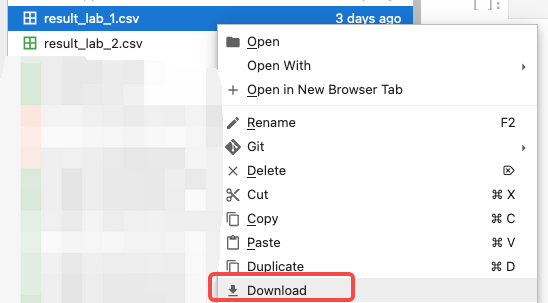